# Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from lazypredict.Supervised import LazyRegressor
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Load data

In [2]:
df = pd.read_csv("data.csv")

# EDA

In [3]:
df.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [4]:
df.tail()

,timestamp,municipality_id,usage,total_capacity
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113
13069,2017-08-19 16:30:35,3,1189,1930


In [5]:
df.describe()

,municipality_id,usage,total_capacity
count,13070.00,13070.00,13070.00
mean,4.50,876.00,1972.80
std,2.87,679.29,1144.07
min,0.00,11.00,397.00
25%,2.00,403.00,697.00
50%,4.50,692.00,1974.50
75%,7.00,1190.00,2947.00
max,9.00,3508.00,3893.00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB


In [7]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 408.6 KB


In [8]:
sorted(df["municipality_id"].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [9]:
df.groupby("municipality_id")["usage"].agg({"count", "mean", "median", "std", "min", "max", "sum"})[["count", "mean", "median", "std", "min", "max", "sum"]]

,count,mean,median,std,min,max,sum
municipality_id,,,,,,,
0,1307,550.56,546.00,245.04,60,1543,719586
1,1307,298.07,319.00,91.77,48,412,389579
2,1307,486.99,507.00,120.39,179,697,636502
3,1307,1078.26,1174.00,371.21,257,1646,1409291
4,1307,2306.51,2559.00,881.38,481,3508,3014607
5,1307,171.48,166.00,99.33,11,582,224124
6,1307,1025.82,1037.00,288.14,399,1920,1340748
7,1307,1149.29,1199.00,272.18,461,1923,1502120
8,1307,1021.75,1107.00,293.39,340,1476,1335421


In [10]:
df.isna().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [11]:
df.duplicated().sum()

0

## Plots

### usage

#### histogram

In [12]:
def plot_histograms(df, col):
    for i in range(10):
        df.loc[df["municipality_id"] == i, col].hist(figsize=(5, 5))
        plt.title(f"municipality_id: {i}")
        plt.xlabel(col)
        plt.show()

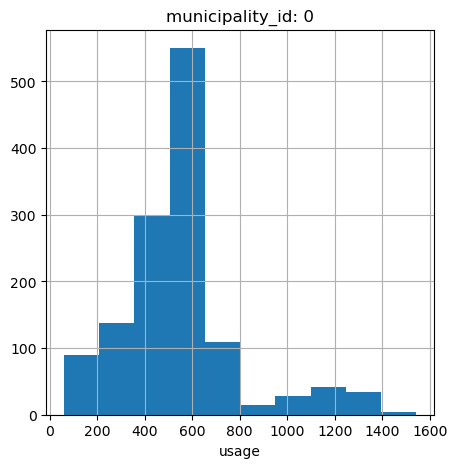

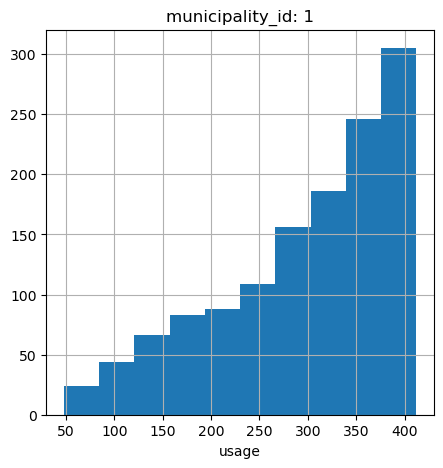

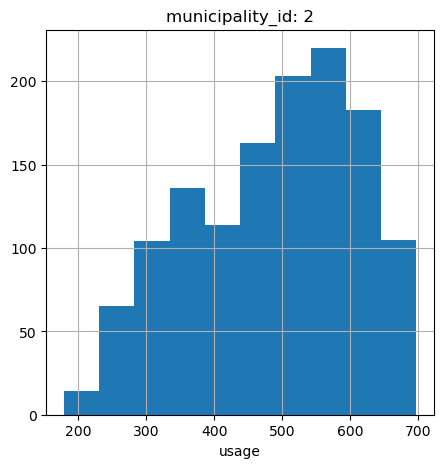

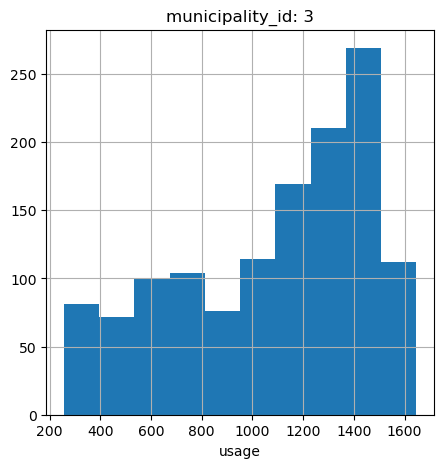

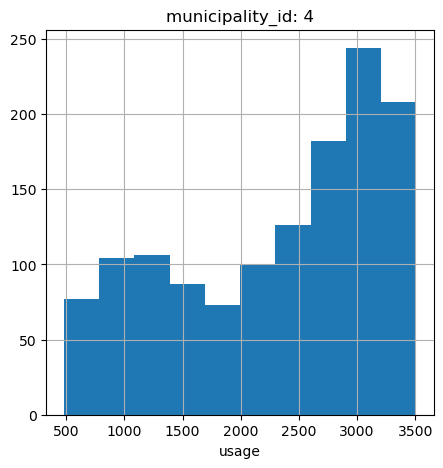

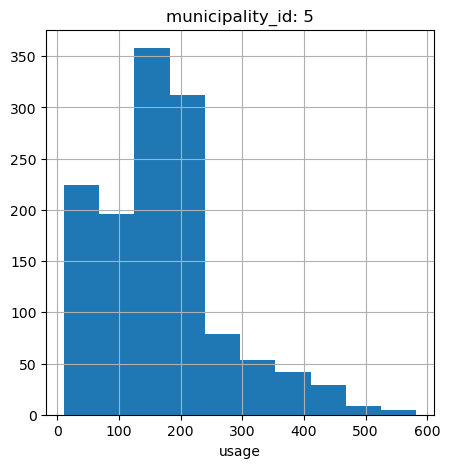

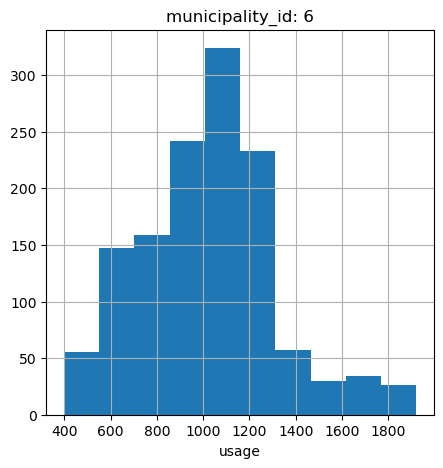

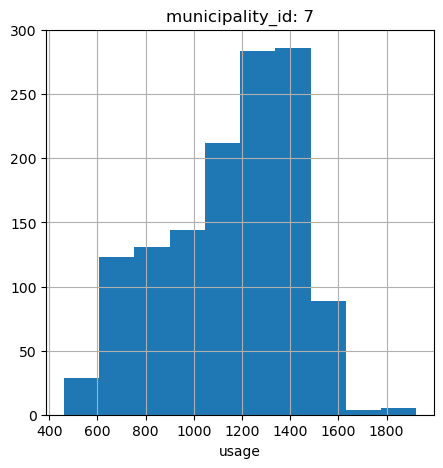

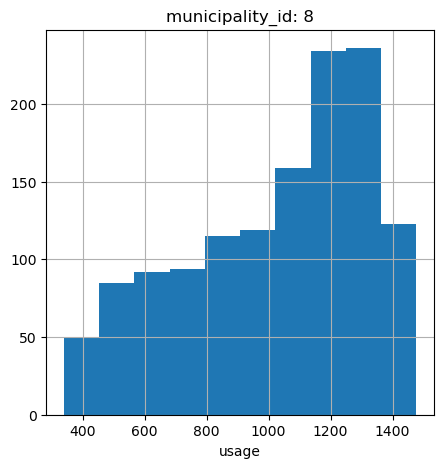

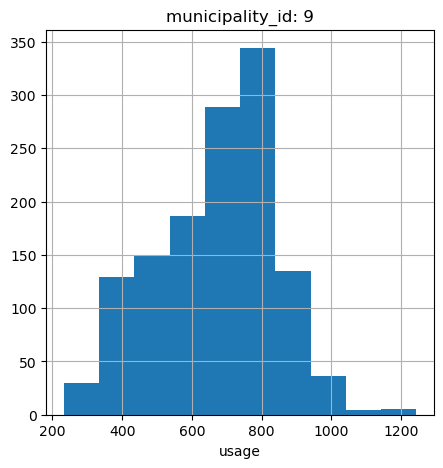

In [13]:
plot_histograms(df, "usage")

#### bar charts

In [14]:
def plot_bars(df_gb, col, agg):
    df_gb[col].agg(agg).plot(kind="bar", figsize=(5, 5))
    plt.title(f"{col} by {agg}")
    plt.show()

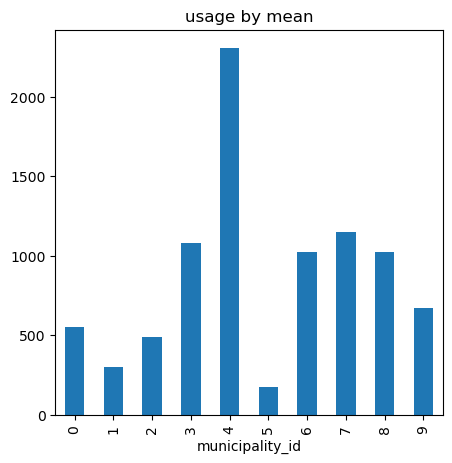

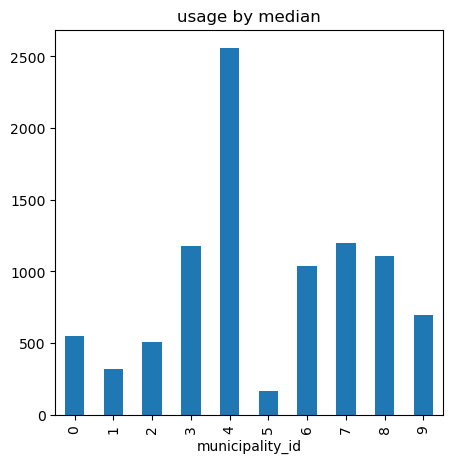

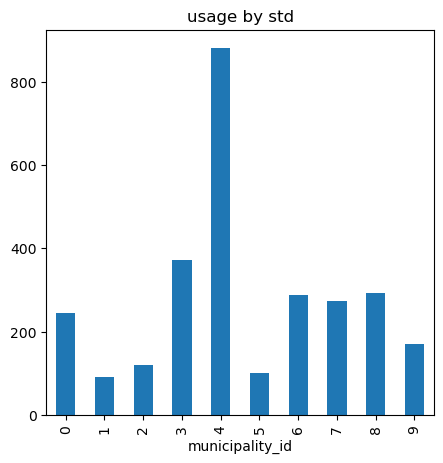

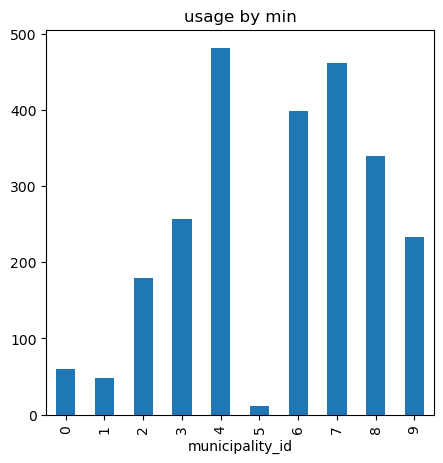

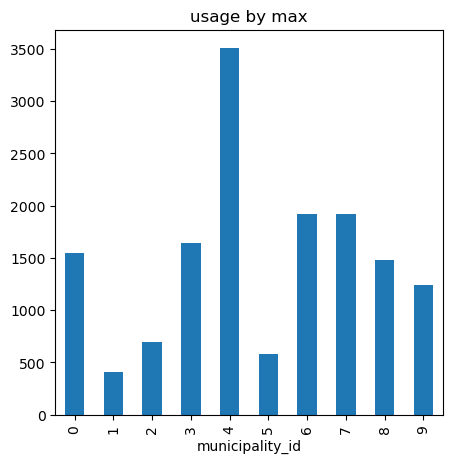

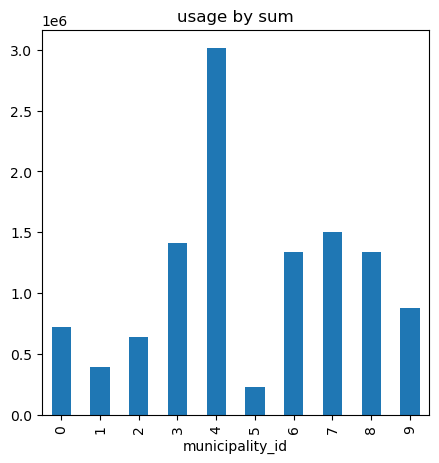

In [15]:
df_gb = df.groupby("municipality_id")
aggs = ["mean", "median", "std", "min", "max", "sum"]

for agg in aggs:
    plot_bars(df_gb, "usage", agg)

### total_capacity

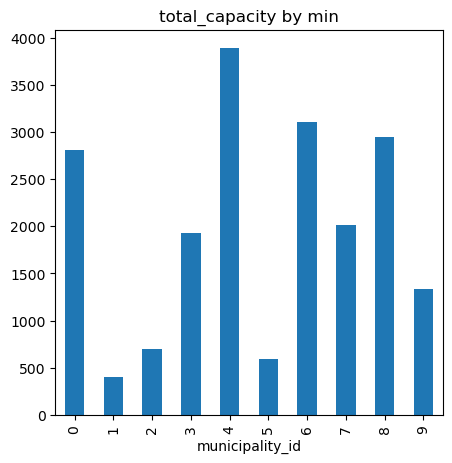

In [16]:
plot_bars(df_gb, "total_capacity", "min")

In [17]:
id2total_capacity = df.groupby("municipality_id")["total_capacity"].min().to_dict()
id2total_capacity

{0: 2813,
 1: 397,
 2: 697,
 3: 1930,
 4: 3893,
 5: 587,
 6: 3113,
 7: 2019,
 8: 2947,
 9: 1332}

We pivot the table to create a dataframe where each row represents an hour for a specific municipality.<br><br>
We replace missing values using linear interpolation and aggregate two measurements for an hour by taking the maximum value.

In [18]:
df = df.pivot_table(values="usage", index="timestamp", columns="municipality_id")
df = df.sort_values(by="timestamp")
df = df.resample("H").max()
df = df.interpolate()
df

municipality_id,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2017-06-04 07:00:00,204.00,129.00,273.00,623.00,1090.00,70.00,597.00,718.00,556.00,454.00
2017-06-04 08:00:00,332.00,164.00,355.00,967.00,2016.00,89.00,801.00,873.00,857.00,527.00
2017-06-04 09:00:00,485.00,245.00,494.00,1263.00,2811.00,159.00,1061.00,1151.00,1172.00,666.00
2017-06-04 10:00:00,583.00,317.00,582.00,1396.00,3178.00,228.00,1219.00,1373.00,1363.00,800.00
2017-06-04 11:00:00,614.00,341.00,643.00,1456.00,3257.00,268.00,1297.00,1479.00,1399.00,845.00
...,...,...,...,...,...,...,...,...,...,...
2017-08-19 12:00:00,1281.00,406.00,663.00,1484.00,3157.00,258.00,1787.00,1503.00,1251.00,849.00
2017-08-19 13:00:00,1283.00,408.00,697.00,1519.00,3194.00,300.00,1845.00,1627.00,1315.00,941.00
2017-08-19 14:00:00,1285.00,410.00,687.00,1530.00,3183.00,318.00,1853.00,1657.00,1341.00,983.00


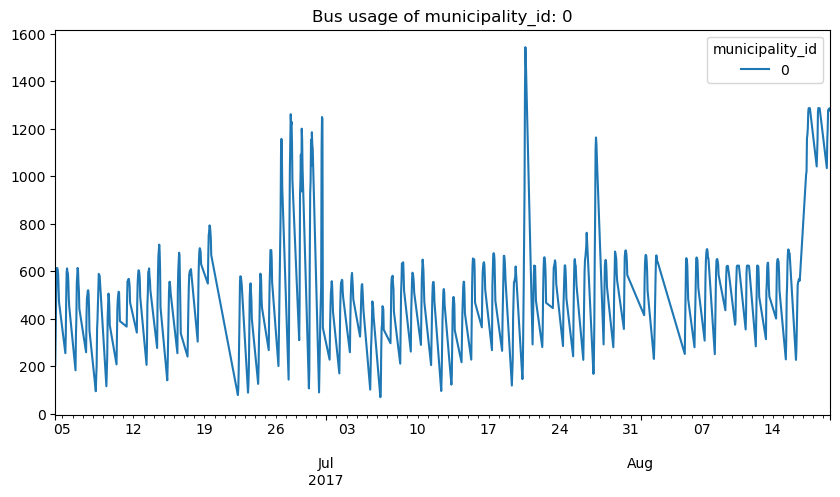

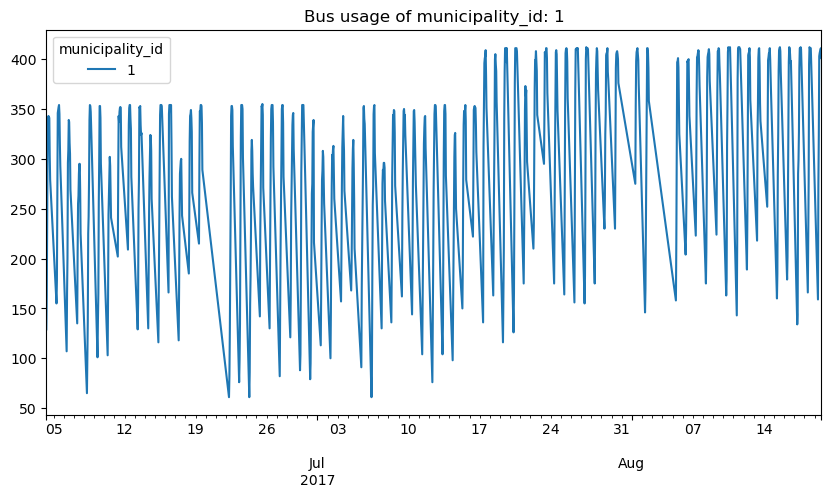

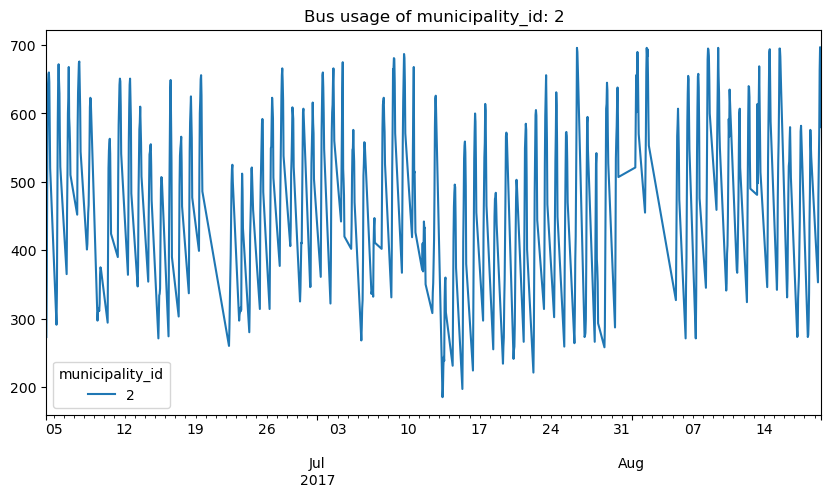

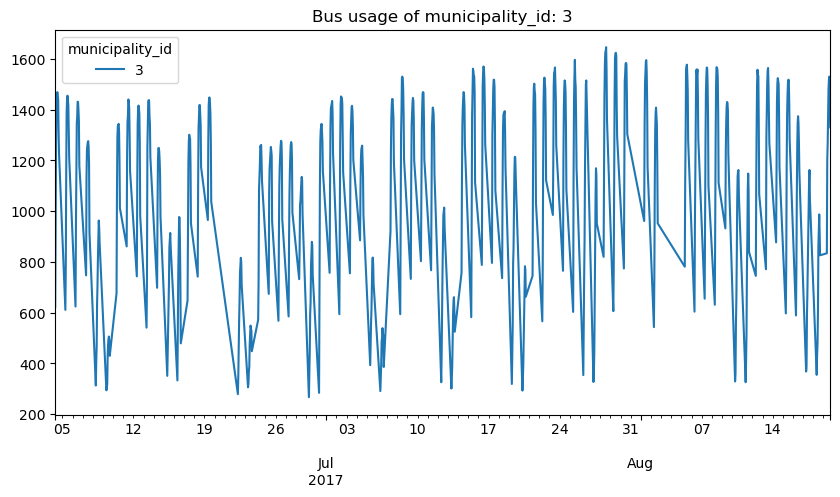

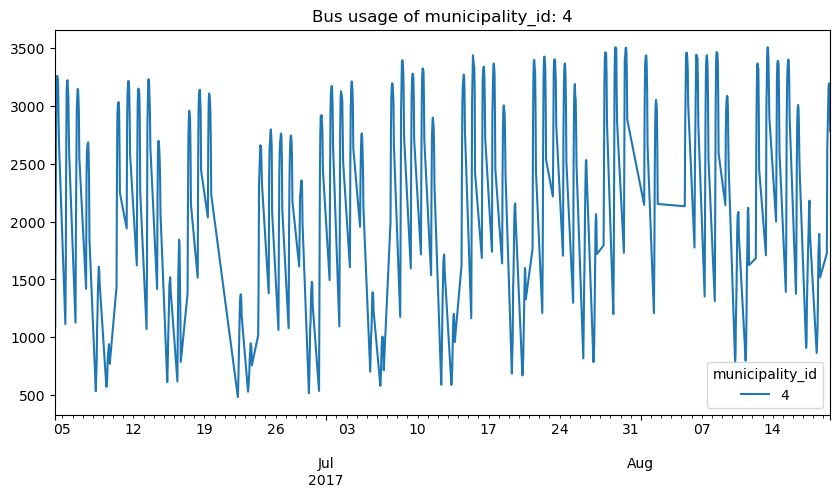

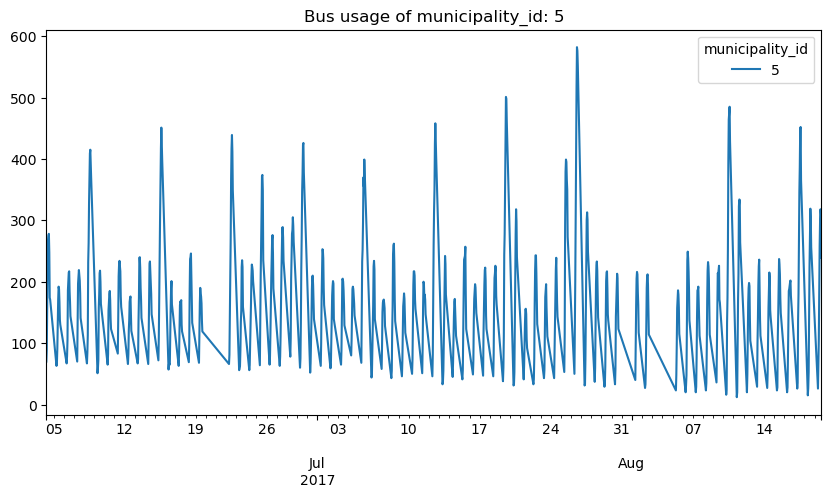

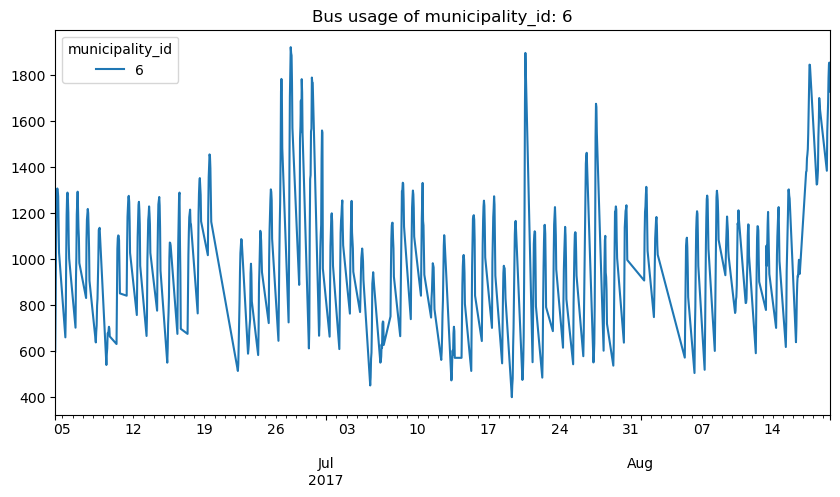

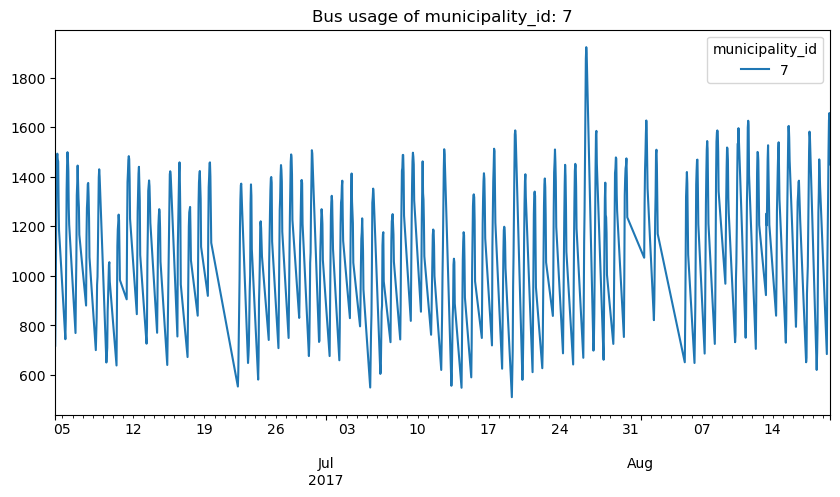

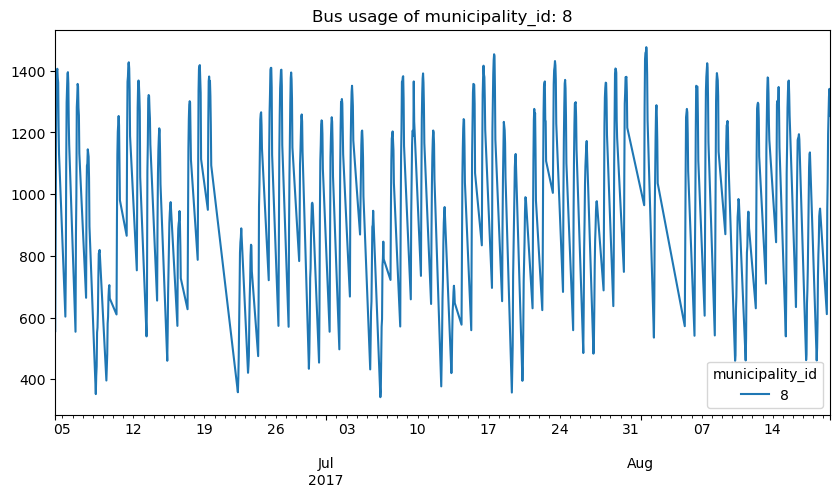

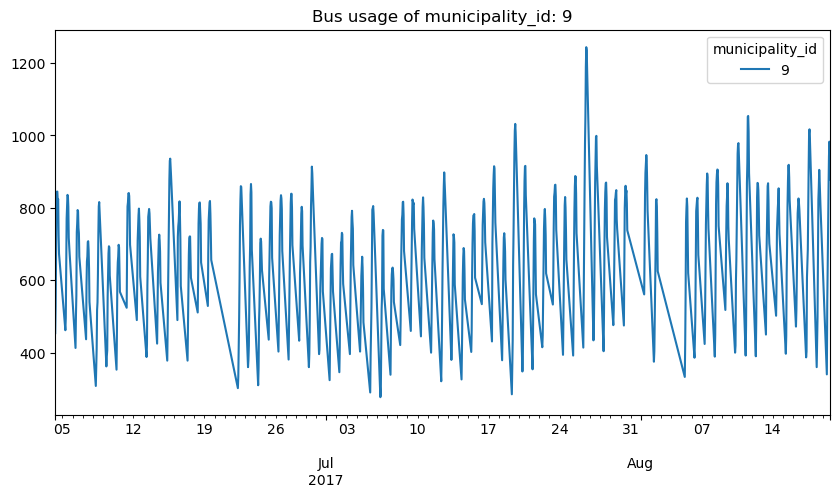

In [19]:
for i in range(10):
    df[[i]].plot(figsize=(10, 5), title=f"Bus usage of municipality_id: {i}")
    plt.xlabel(None)
    plt.show()

### Create lag features

In [20]:
def create_lag_features(df):
    for i in range(10):
        for j in range(1, 25):
            df[f"{i}_lag{j}"] = df[i].shift(j)
            df[f"{i}_change_lag{j}"] = df[f"{i}_lag{j}"].diff()
    return df

In [21]:
df = create_lag_features(df)
df = df.dropna()
df

municipality_id,0,1,2,3,4,5,6,7,8,9,...,9_lag20,9_change_lag20,9_lag21,9_change_lag21,9_lag22,9_change_lag22,9_lag23,9_change_lag23,9_lag24,9_change_lag24
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-05 08:00:00,335.00,178.00,339.00,788.00,1608.00,68.00,769.00,826.00,745.00,496.00,...,845.00,0.00,845.00,45.00,800.00,134.00,666.00,139.00,527.00,73.00
2017-06-05 09:00:00,487.00,265.00,473.00,1147.00,2561.00,92.00,1012.00,1099.00,1092.00,635.00,...,820.00,-25.00,845.00,0.00,845.00,45.00,800.00,134.00,666.00,139.00
2017-06-05 10:00:00,595.00,346.00,587.00,1388.00,3126.00,137.00,1191.00,1348.00,1297.00,770.00,...,824.00,4.00,820.00,-25.00,845.00,0.00,845.00,45.00,800.00,134.00
2017-06-05 11:00:00,612.00,349.00,649.00,1439.00,3203.00,171.00,1268.00,1445.00,1349.00,805.00,...,725.00,-99.00,824.00,4.00,820.00,-25.00,845.00,0.00,845.00,45.00
2017-06-05 12:00:00,595.00,352.00,672.00,1455.00,3222.00,192.00,1288.00,1499.00,1390.00,836.00,...,673.00,-52.00,725.00,-99.00,824.00,4.00,820.00,-25.00,845.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-19 12:00:00,1281.00,406.00,663.00,1484.00,3157.00,258.00,1787.00,1503.00,1251.00,849.00,...,834.00,-41.00,875.00,-30.00,905.00,47.00,858.00,34.00,824.00,154.00
2017-08-19 13:00:00,1283.00,408.00,697.00,1519.00,3194.00,300.00,1845.00,1627.00,1315.00,941.00,...,803.12,-30.88,834.00,-41.00,875.00,-30.00,905.00,47.00,858.00,34.00
2017-08-19 14:00:00,1285.00,410.00,687.00,1530.00,3183.00,318.00,1853.00,1657.00,1341.00,983.00,...,772.25,-30.88,803.12,-30.88,834.00,-41.00,875.00,-30.00,905.00,47.00


### Forecasting using naive method
#### split train and test

In [22]:
train = df.loc["2017-06-04":"2017-08-04"]
test = df.loc["2017-08-05":"2017-08-19"]

In [23]:
naive = test.shift(1)
naive.iloc[0] = train.iloc[-1]

In [24]:
rmse = mean_squared_error(test, naive, squared=False)

print(f"Naive method MAE: {rmse:.2f}")

Naive method MAE: 69.08


In [25]:
print("Naive method RMSEs by municipality_id:")

naive_rmses = []
for i in range(10):
    rmse = mean_squared_error(test[i], naive[i], squared=False)
    print(f"municipality_id: {i} RMSE: {rmse:.2f}")
    naive_rmses.append(rmse)

Naive method RMSEs by municipality_id:
municipality_id: 0 RMSE: 41.96
municipality_id: 1 RMSE: 29.90
municipality_id: 2 RMSE: 36.84
municipality_id: 3 RMSE: 103.01
municipality_id: 4 RMSE: 215.88
municipality_id: 5 RMSE: 30.69
municipality_id: 6 RMSE: 62.31
municipality_id: 7 RMSE: 90.75
municipality_id: 8 RMSE: 81.24
municipality_id: 9 RMSE: 57.50


## Complex model

### Let's check which vanilla model is the best with LazyRegressor from the LazyPredict package

In [26]:
lag_cols = [col for col in train.columns if "_lag" in str(col)]

In [27]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(train[lag_cols], test[lag_cols], train[0], test[0])
print(models)

100%|██████████| 42/42 [02:29<00:00,  3.55s/it]

                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
Lars                                       138.26     -48.91 2016.44   
GaussianProcessRegressor                    16.26      -4.55  672.44   
KernelRidge                                  8.19      -1.61  461.51   
QuantileRegressor                            4.92      -0.43  340.85   
DummyRegressor                               4.64      -0.32  328.20   
SVR                                          4.52      -0.28  322.84   
NuSVR                                        4.50      -0.27  321.89   
KNeighborsRegressor                          3.14       0.22  251.87   
PoissonRegressor                             1.99       0.64  170.91   
GammaRegressor                               1.90       0.67  163.55   
ExtraTreeRegressor                           1.82       0.70  156.28   
MLPRegressor                                 1.77       0.72  15

#### Top performer model is HuberRegressor. Let's use it for the rest of the modeling.

In [30]:
from sklearn.linear_model import HuberRegressor

regressors = []
rmses = []
for m_id in range(10):
    reg = LazyRegressor(verbose=0, custom_metric=None, regressors=[HuberRegressor])
    reg.fit(train[lag_cols], test[lag_cols], train[m_id], test[m_id])
    regressors.append(reg)
    preds = reg.models["HuberRegressor"].predict(test[lag_cols])
    test[f"preds_{m_id}"] = preds
    rmse = mean_squared_error(test[m_id], preds, squared=False)
    rmses.append(rmse)

100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


### Comparison between naive model vs complex model

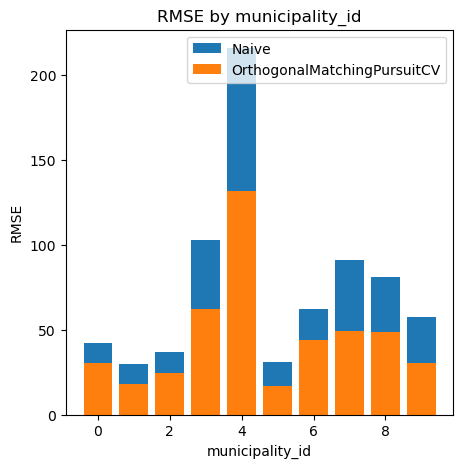

In [31]:
plt.figure(figsize=(5, 5))
plt.bar(range(10), naive_rmses)
plt.bar(range(10), rmses)
plt.title("RMSE by municipality_id")
plt.xlabel("municipality_id")
plt.ylabel("RMSE")
plt.legend(["Naive", "OrthogonalMatchingPursuitCV"])
plt.show()

### Plot the actual vs predicted on test data

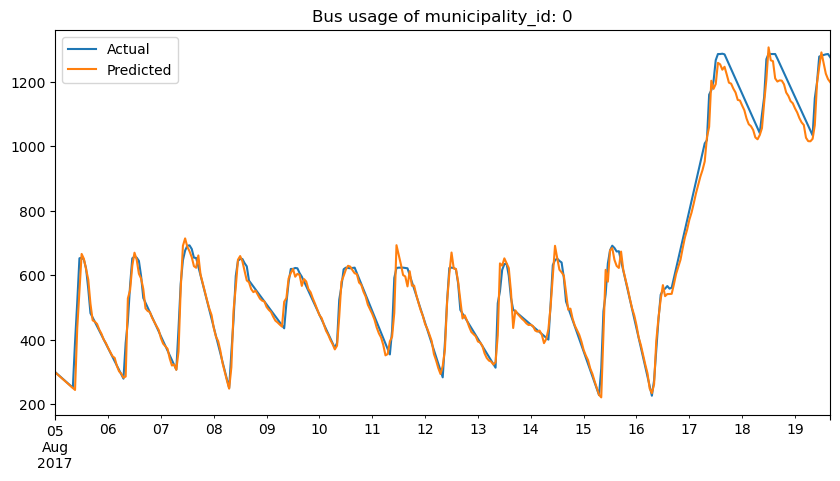

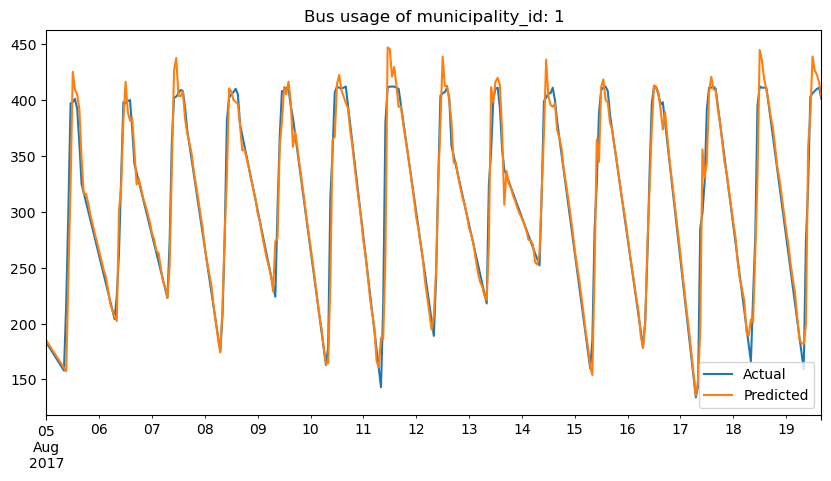

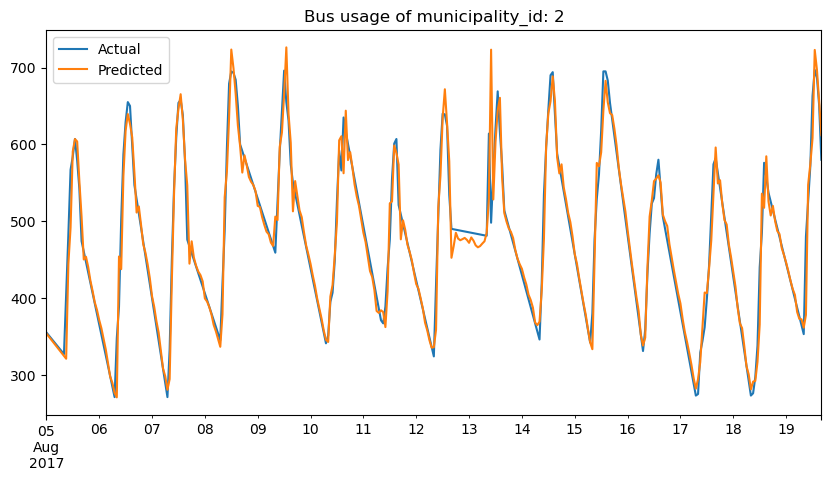

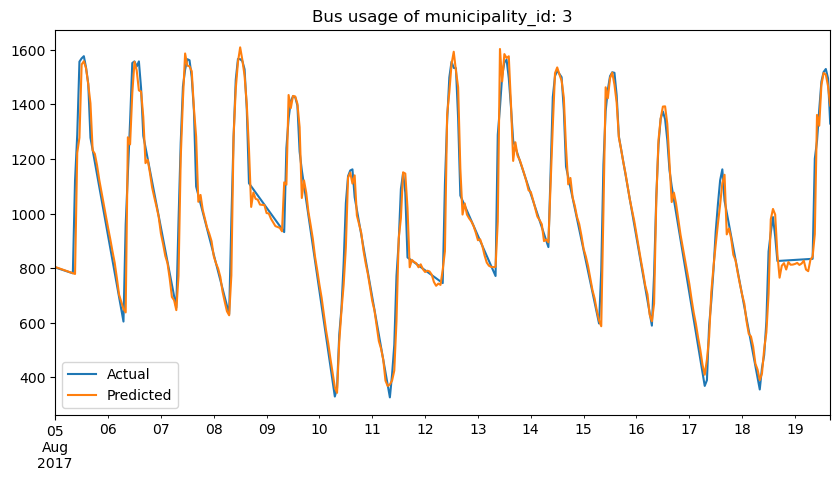

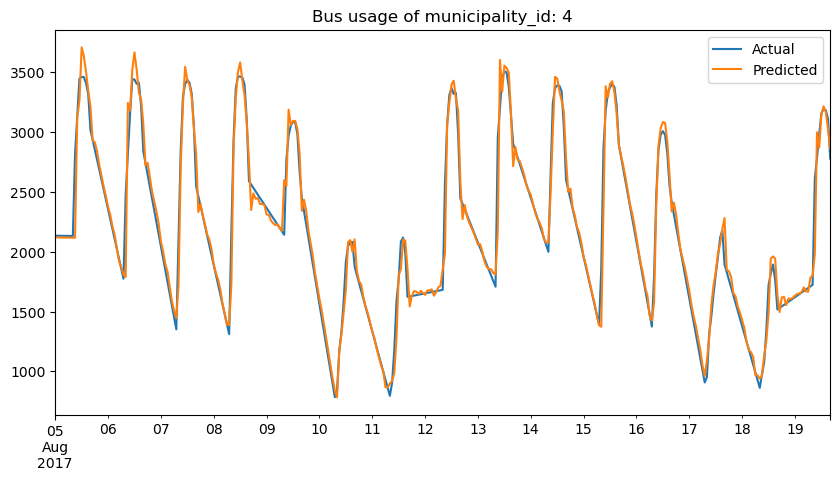

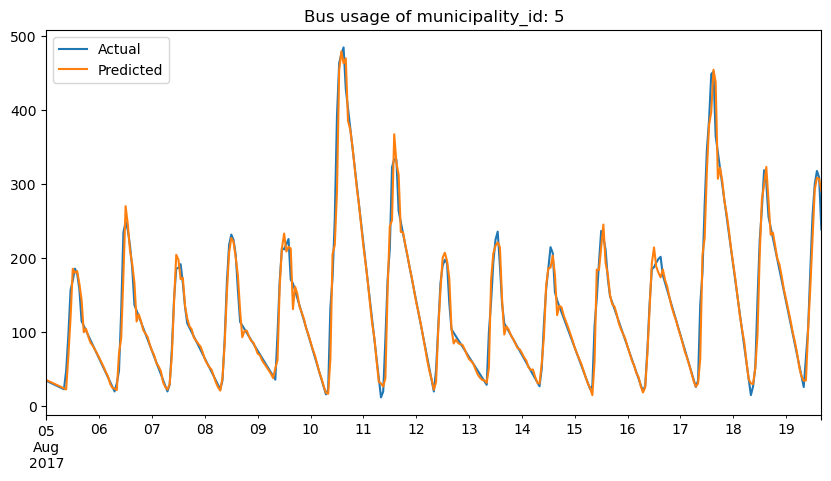

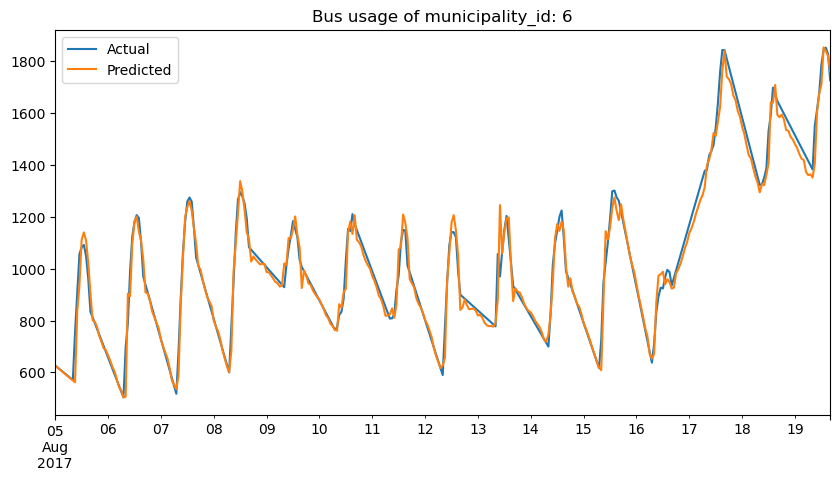

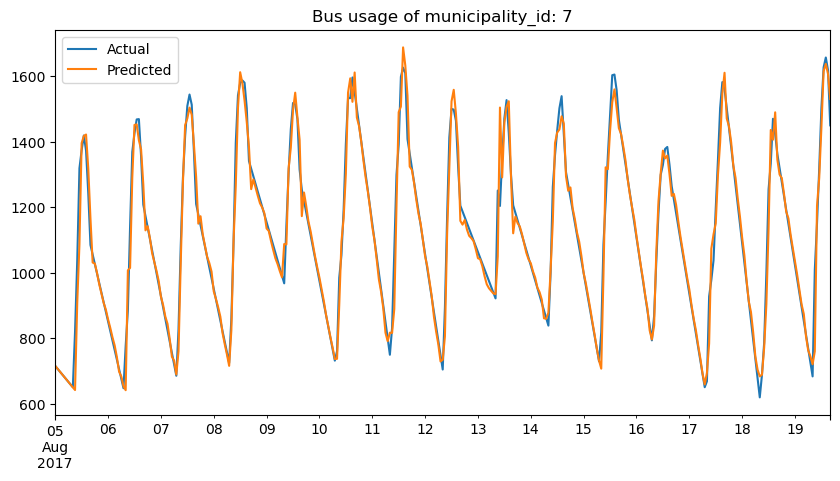

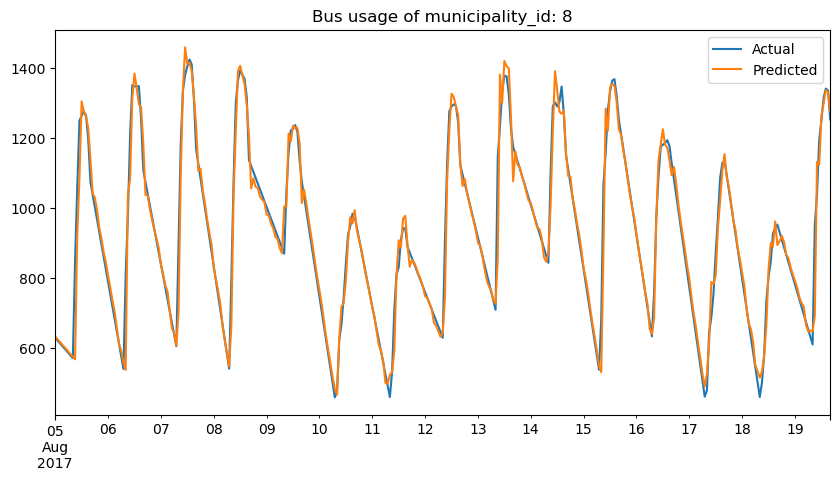

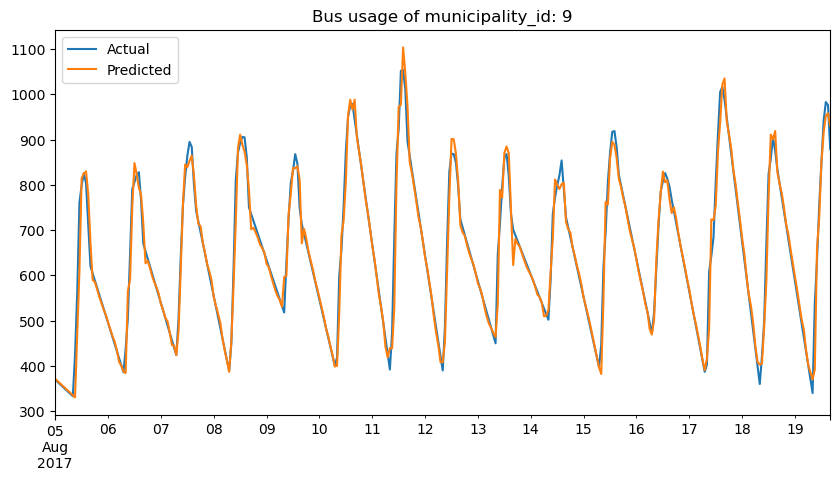

In [32]:
for i in range(10):
    preds = regressors[i].models["HuberRegressor"].predict(test[lag_cols])
    test[[i, f"preds_{i}"]].plot(figsize=(10, 5), title=f"Bus usage of municipality_id: {i}", label="Actual")
    plt.xlabel(None)
    plt.legend(["Actual", "Predicted"])
    plt.show()

# Forecasting
### Forecast the hourly demands for the next week
### Therefore, we need make 168 predictions

In [33]:
date_range = pd.date_range(start="2017-08-19 17:00:00", end=pd.to_datetime("2017-08-19 17:00:00") + pd.Timedelta("167 hours"), freq="H")

df_tmp = pd.DataFrame(date_range, columns=["timestamp"])
df_tmp = df_tmp.set_index("timestamp")
df_tmp

""
timestamp
2017-08-19 17:00:00
2017-08-19 18:00:00
2017-08-19 19:00:00
2017-08-19 20:00:00
2017-08-19 21:00:00
...
2017-08-26 12:00:00
2017-08-26 13:00:00
2017-08-26 14:00:00


#### Get forecasts, store them in a dataframe: df_results

In [34]:
df_results = df[[i for i in range(10)]].copy()
for row, _ in tqdm(df_tmp.iterrows(), total=df_tmp.shape[0]):
    df_results = df_results.append(pd.Series(name=row))

    for i in range(10):
        for j in range(1, 25):
            df_results[f"{i}_lag{j}"] = df_results[i].shift(j)
            df_results[f"{i}_change_lag{j}"] = df_results[f"{i}_lag{j}"].diff()

    for i in range(10):
        df_results.loc[row, i] = regressors[i].models["HuberRegressor"].predict(pd.DataFrame(df_results.loc[row, lag_cols]).T)

  0%|          | 0/168 [00:00<?, ?it/s]

#### Plot predictions

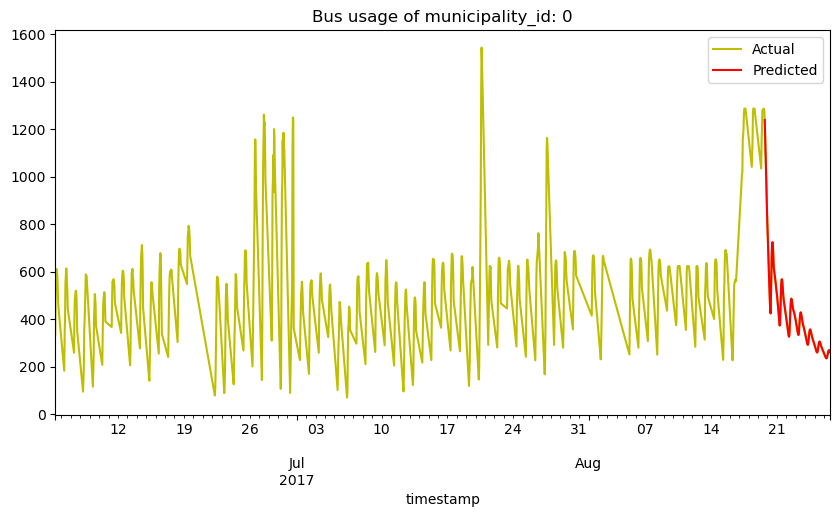

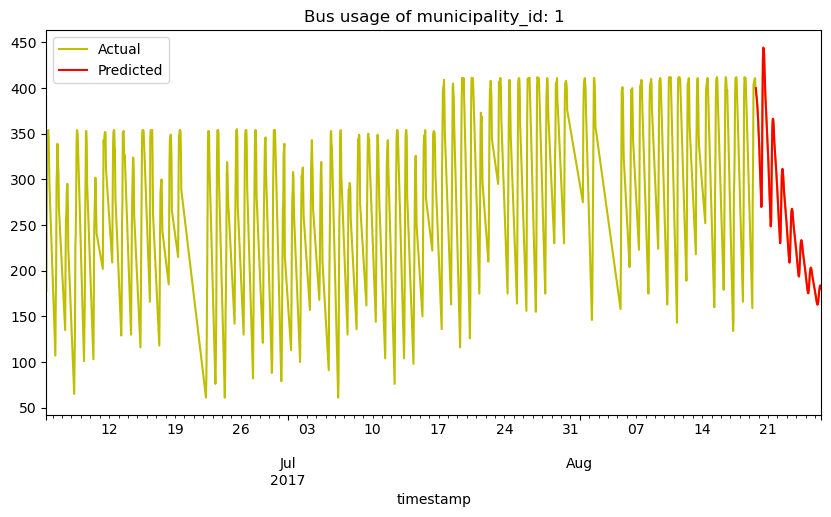

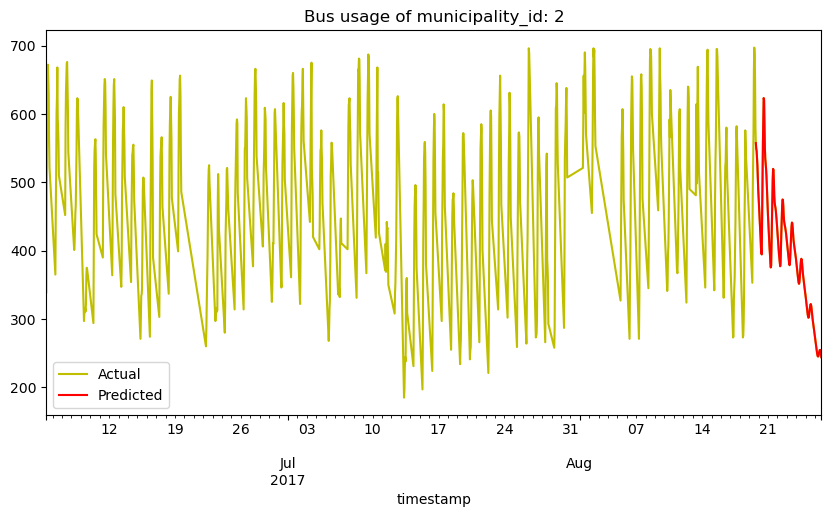

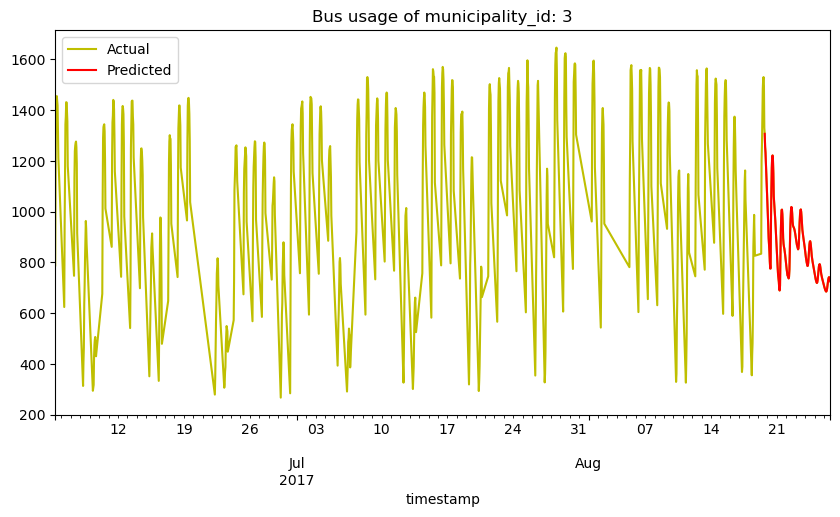

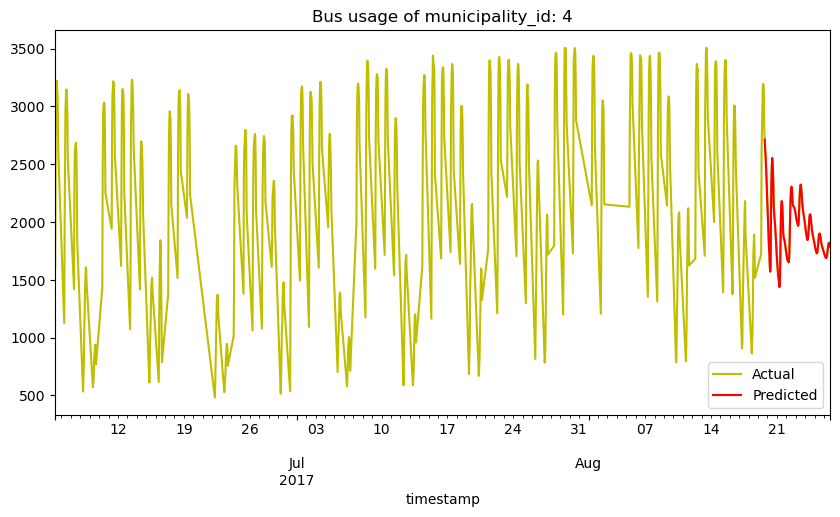

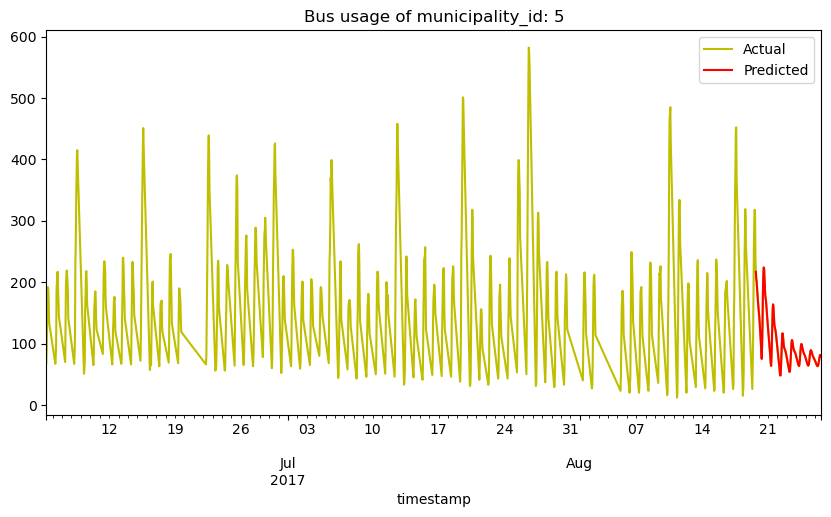

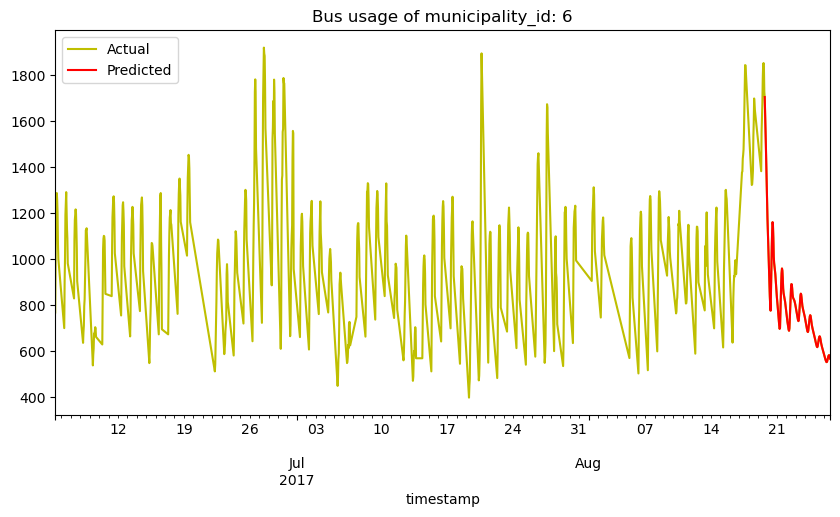

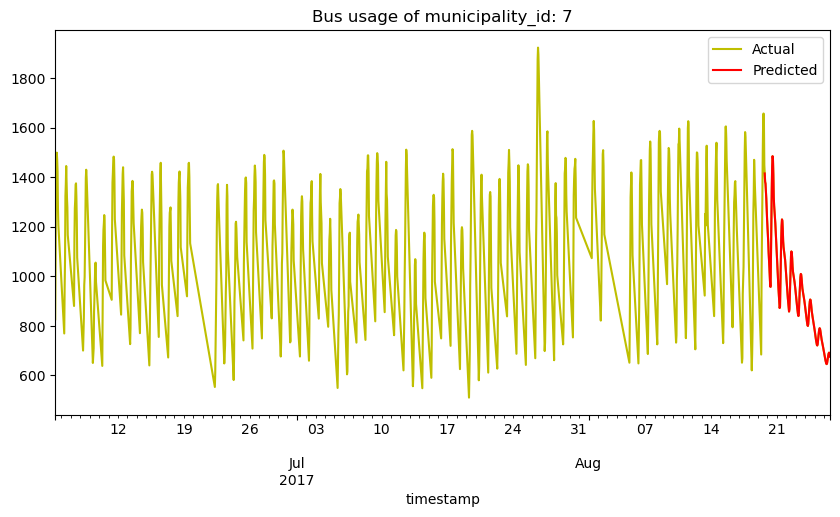

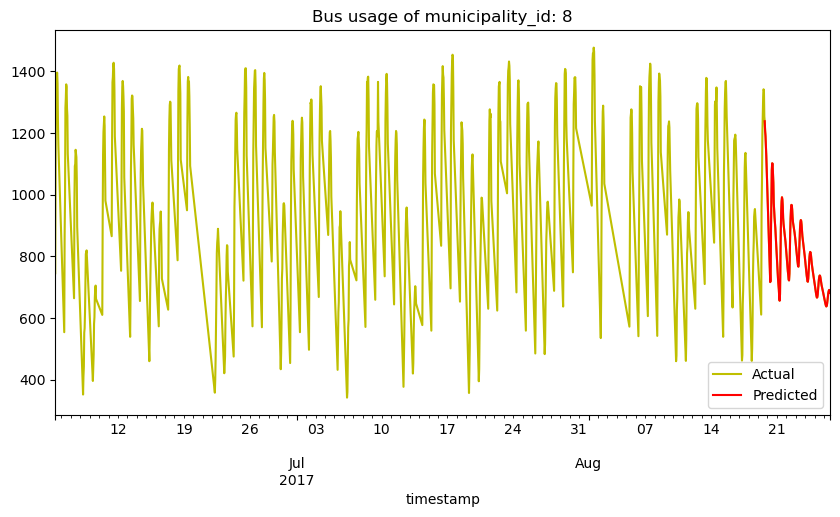

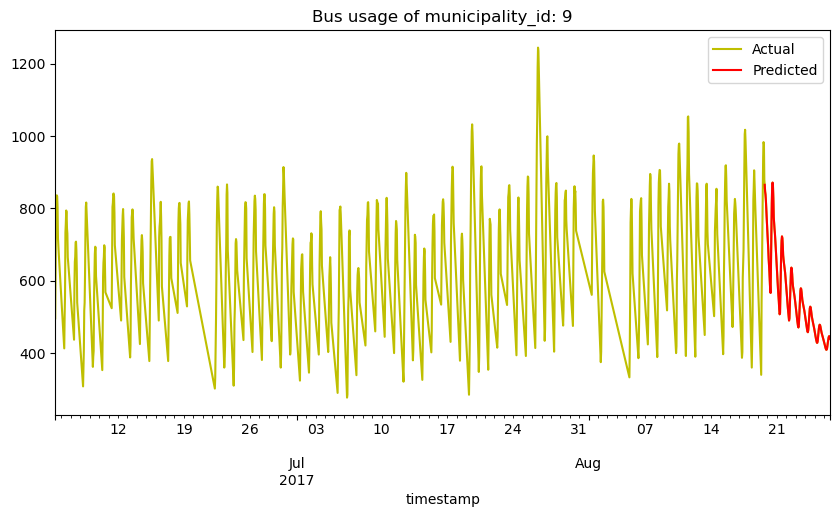

In [35]:
for i in range(10):
    ax = df_results[[i]].plot(figsize=(10, 5), title=f"Bus usage of municipality_id: {i}", label="Actual", color="y")
    df_results.loc[df_results.index >= "2017-08-19 17:00:00", [i]].plot(ax=ax, color="r", label="Predicted")
    plt.legend(["Actual", "Predicted"])
    plt.show()

#### Save results

In [36]:
df_results.to_csv("results.csv")